<a href="https://colab.research.google.com/github/UjalaWKarim/Kaggle_House_Prices_Dataset/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

In [17]:
df=pd.read_csv('Housing2.csv')

In [18]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [20]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [21]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [22]:
df.isnull().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [23]:
df.duplicated().sum()

np.int64(0)

In [52]:
# Interaction terms
df['bed_bath'] = df['bedrooms'] * df['bathrooms']
df['area_per_room'] = df['area'] / (df['bedrooms'] + df['bathrooms'])
df['luxury_score'] = df[['airconditioning', 'hotwaterheating', 'prefarea']].sum(axis=1)

In [25]:
# Convert yes/no to 1/0
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))

In [26]:
# One-Hot encoding
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)


In [30]:
# Polynomial and non-polynomial features
df['area_squared'] = df['area'] ** 2
df['log_area'] = np.log1p(df['area'])

In [31]:
# Convert continuous variables into categories
df['area_bin'] = pd.qcut(df['area'], q=3, labels=['small', 'medium', 'large'])
df = pd.get_dummies(df, columns=['area_bin'], drop_first=True)

In [33]:
# Mean encoding
furnish_mean = df.groupby('furnishingstatus_unfurnished')['price'].mean()
df['furnish_mean_encoded'] = df['furnishingstatus_unfurnished'].map(furnish_mean)

In [51]:
# Log transformation
df['log_price'] = np.log1p(df['price'])
df['log_area'] = np.log1p(df['area'])

In [55]:
# Outlier detection and removal
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

In [58]:
# Recursive feature elimination
model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X, y)
X_selected = X.loc[:, rfe.support_]

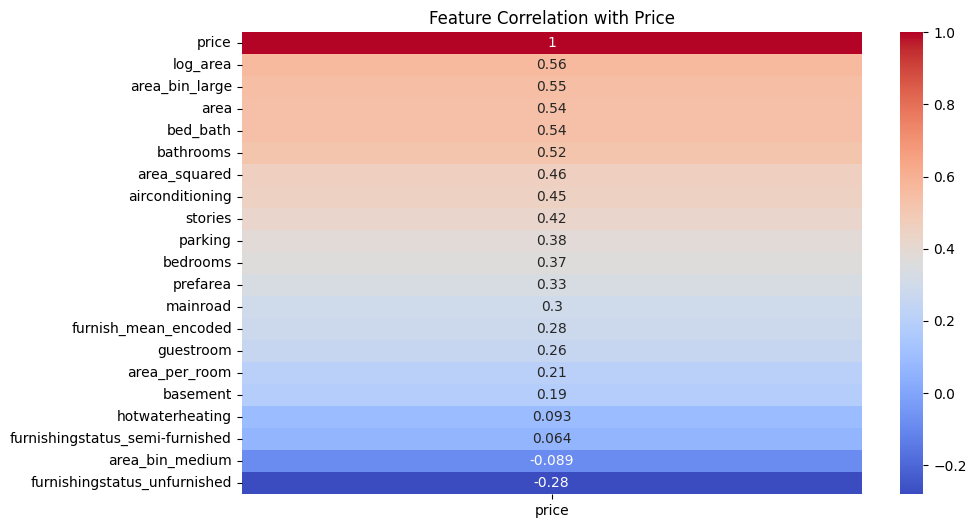

In [35]:
# Correlation with price
plt.figure(figsize=(10,6))
sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Price")
plt.show()

In [39]:
# Feature importance
X = df.drop('price', axis=1)
y = df['price']

In [40]:
model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

In [41]:
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importance)

bed_bath                           0.177575
area                               0.148170
area_squared                       0.147749
log_area                           0.116639
area_per_room                      0.079492
parking                            0.057700
airconditioning                    0.050731
stories                            0.036993
prefarea                           0.034995
basement                           0.021941
furnishingstatus_unfurnished       0.018840
bathrooms                          0.018294
furnish_mean_encoded               0.016881
hotwaterheating                    0.015860
guestroom                          0.015540
furnishingstatus_semi-furnished    0.012767
bedrooms                           0.012665
mainroad                           0.007990
area_bin_large                     0.007254
area_bin_medium                    0.001923
dtype: float64


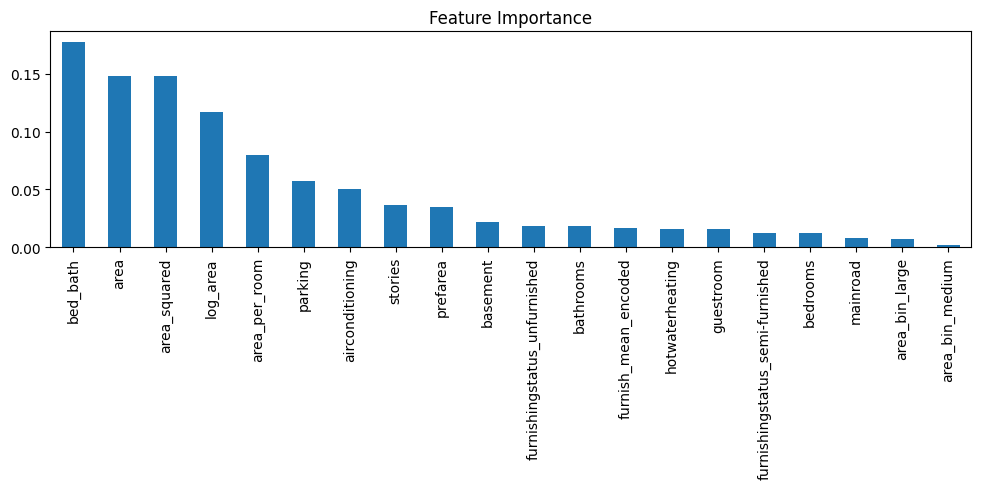

In [42]:
importance.plot(kind='bar', figsize=(10, 5), title='Feature Importance')
plt.tight_layout()
plt.show()

In [45]:
# Linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [47]:
y_pred = lr.predict(X_test)

In [49]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", rmse)

R2 Score: 0.6480279699838984
RMSE: 1333816.8354276468


In [76]:
# Scalarization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
# Ridge regression
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=[0.1, 1.0, 10.0])

In [85]:
y_pred_ridge = ridge.predict(X_test_scaled)

In [86]:
print("Ridge Regression Results")
print("Best alpha:", ridge.alpha_)
print("R2 Score:", r2_score(y_test, y_pred_ridge))
mse = mean_squared_error(y_test, y_pred_ridge)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Ridge Regression Results
Best alpha: 0.1
R2 Score: 0.6484078130366124
RMSE: 1333096.9233621715


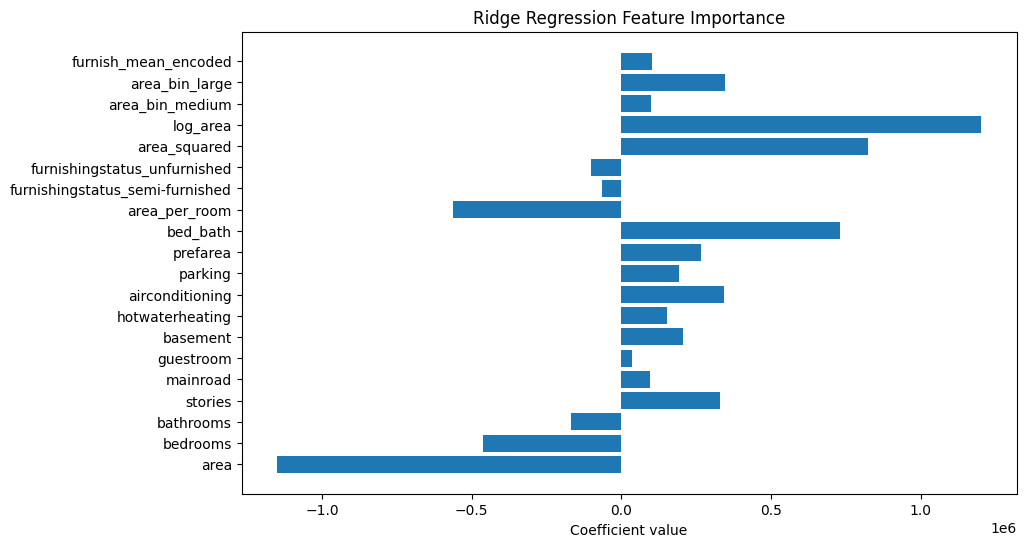

In [88]:
# Ridge coefficients
coef = ridge.coef_
features = X_train.columns

plt.figure(figsize=(10,6))
plt.barh(features, coef)
plt.xlabel("Coefficient value")
plt.title("Ridge Regression Feature Importance")
plt.show()

In [89]:
# Lasso regression
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196041282913.1875, tolerance: 119217368774.45206
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205732491309.875, tolerance: 119217368774.45206
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204792781387.375, tolerance: 119217368774.45206
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWa

LassoCV(cv=5)

In [90]:
y_pred_lasso = lasso.predict(X_test_scaled)

In [91]:
print("\nLasso Regression Results")
print("Best alpha:", lasso.alpha_)
print("R2 Score:", r2_score(y_test, y_pred_lasso))
mse = mean_squared_error(y_test, y_pred_lasso)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


Lasso Regression Results
Best alpha: 3105.3428700558998
R2 Score: 0.6500574484964222
RMSE: 1329965.8675188597


In [92]:
print("Number of features used:", np.sum(lasso.coef_ != 0))

Number of features used: 17
